1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

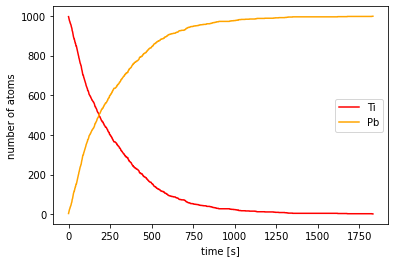

In [3]:
import numpy as np
from matplotlib import pyplot as plt

half_life = 3.052 * 60
sample_Ti_init = 1000
sample_Pb_init = 0

sample_Ti_t = sample_Ti_init #initialization at t=0
sample_Pb_t = sample_Pb_init #initialization at t=0

#to be plot
Ti = []
Pb = []
steps = np.arange(0, half_life * 10, 1)

for i in steps:
    for j in range(sample_Ti_t):
        if np.random.rand() < 1 - 2**(-1. / half_life):
            
            sample_Ti_t -= 1
            sample_Pb_t = sample_Ti_init - sample_Ti_t #number of lead as the subtraction

    Ti.append(sample_Ti_t)
    Pb.append(sample_Pb_t)

plt.plot(steps, Ti, label = 'Ti', color = 'red')
plt.plot(steps, Pb, label = 'Pb', color = 'orange')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('number of atoms')

plt.show()

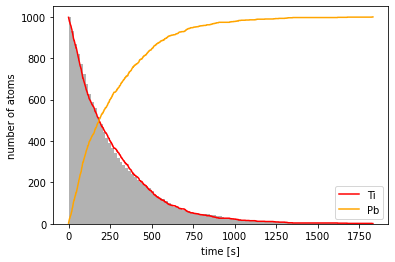

In [4]:
x = np.random.uniform(0,1,1000)

def expon_icdf(p, mu = (np.log(2) / half_life ) ):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return - np.log(1 - p) / mu
x = expon_icdf(x)

plt.hist(x, bins = 100, cumulative = -1, color = 'black', alpha = 0.3)
plt.plot(steps, Ti, label = 'Ti', color = 'red')
plt.plot(steps, Pb, label = 'Pb', color = 'orange')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('number of atoms')
plt.show()


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

1572 (more or less 1.55‰)


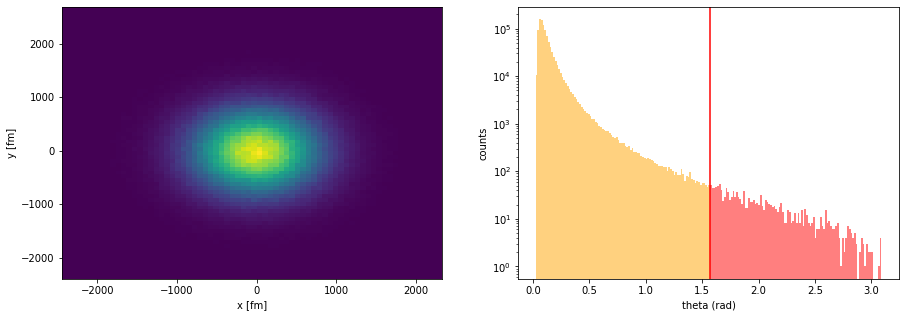

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd

#constants
Z_Au = 79
e =  1.44 *2. #MeV*fm
E = 7.7 #MeV
a_0 = 5.29e4 #fm
#epsilon_0 = 1

fig, axes = plt.subplots(1,2, figsize=(15,5))

particles = 1000000
x = np.random.normal(0, a_0 / 100, particles)
y = np.random.normal(0, a_0 / 100, particles)

axes[0].hist2d(x, y, bins = 70)
axes[0].set_xlabel('x [fm]')
axes[0].set_ylabel('y [fm]')

def theta_calc(x, y, Z_Au, E):
    b = np.sqrt(x**2 + y**2)
    return 2 * np.arctan((Z_Au * e) / (E * b))

thetas = theta_calc(x, y, Z_Au, E)

thetas_acc = thetas[thetas < np.pi/2]
thetas_rej = thetas[thetas > np.pi/2]

axes[1].hist(thetas_acc, bins = 100, alpha = 0.5, color = 'orange')
axes[1].hist(thetas_rej, bins = 100, alpha = 0.5, color = 'red')
axes[1].set_yscale('log')
axes[1].axvline(np.pi / 2.0, color = 'red')
axes[1].set_xlabel('theta (rad)')
axes[1].set_ylabel('counts')

print(thetas_rej.shape[0], '(more or less 1.55‰)')
plt.show()

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

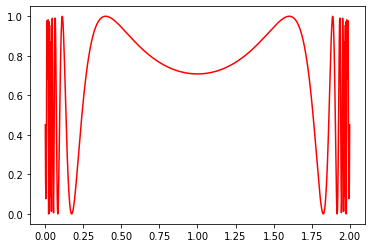

In [9]:
def f(x):
    return (np.sin(1 / (x * (2 - x))))**2

x = np.linspace(0.001, 1.999, 1000)
plt.plot(x, f(x), 'r-')
plt.show()

N = 100000

def h_or_m(f, N, a, b):
    acc_count = 0
    for i in range(N):
        x = np.random.uniform(a, b)
        y = np.random.random()
        if y < f(x): acc_count += 1
    return 2 * acc_count / N #see the ratio of hits (y<f) over the total number

def mean_value(f, N, a, b):
    x = np.random.uniform(a, b, N)
    y = f(x)
    stdev = np.std(y)
    err = 2. * stdev / np.sqrt(N)
    return 2. * np.mean(y), err

In [10]:
trials = np.zeros(10)
for i in range(10):
    trials[i] = h_or_m(f ,N, 0., 2.)
err_I_hm = np.std(trials)

print('Area with Monte Carlo - hit or miss integration is:', h_or_m(f, N, 0., 2.))
print('Error:', err_I_hm)


ave, err = mean_value(f, N, 0., 2.)
print('\nArea with Monte Carlo - mean value integration is:', ave)
print('Error:', err)

Area with Monte Carlo - hit or miss integration is: 1.45272
Error: 0.003074348711516012

Area with Monte Carlo - mean value integration is: 1.4511412185969725
Error: 0.0016658753218187431


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [40]:
def f(x): 
    b = 0
    a = np.sum(x**2)
    if a <= 1: 
        b = 1
    else: 
        b = 0
    return b

N = 100000
dim = 10

def area_circle(N):
    points = np.random.uniform(-1., 1., size = (N, 2))
    hits = 0
    for i in range(N):
        hits += f(points[i])
    V = (2.0**2) * hits / N
    return V

def hypervolume(N, dim):
    points = np.random.uniform(-1., 1., size = (N, dim))
    hits = 0
    for i in range(N):
        hits += f(points[i])
    V = (2.0**dim) * hits / N
    return V
    
print('Area of a unitary circle: ', area_circle(N))
print('Area of a 10D hypersphere: ', hypervolume(N,dim))

Area of a unitary circle:  3.13924
Area of a 10D hypersphere:  2.52928


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [41]:
import numpy as np

def w(x):
    return 1.0 / np.sqrt(x)

def inv_tr_w(x):
    return x**2

def f(x):
    return x**(-0.5) / (np.exp(x) + 1)

def imp_samp(N, a, b):
    x = np.random.uniform(a, b, size = N)
    ws = inv_tr_w(x)
    c = np.sum(f(ws) / w(ws))
    return 1./N *c * 2.0 

print(imp_samp(N, 0, 1.0))

0.8387350316008919
